# [ EXPLORATION ] 6. 작사가 인공지능 만들기

✅LSTM 모델과 셰익스피어 데이터셋을 사용해 간단한 작사가 인공지능을 만들어 본다.

---
### - 📖목차
* ✔️6-7. 프로젝트: 멋진 작사가 만들기
    <br>1-1. 어떤 단어들로 이루어진 문장들이 모여있을까?
    <br>1-2. 단어들의 빈도수를 시각화로 한눈에 확인하기
* ✔️회고 및 결론
* ✔️Reference(참고자료)

<br>



## ✔️6-7. 프로젝트: 멋진 작사가 만들기
---
### Step 1. 데이터 다운로드


In [1]:
import tensorflow as tf
print("- 현재 연결된 [ GPU ]개수 : ", len(tf.config.experimental.list_physical_devices('GPU')))

- 현재 연결된 [ GPU ]개수 :  1


In [80]:
# 모듈 불러오기
import glob
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import re #정규표현식을 위한 모듈
import itertools #효율적인 이터레이터(반복작업)을 위한 툴 모듈
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow import keras

In [13]:
# 데이터 불러오기(colab - google drive 마운트)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
# aiffel에서 가져온 파일이 제대로 업로드 됐는지 확인
!ls '/content/drive/MyDrive/aiffel/ex_06/lyrics'

adele.txt	       dolly-parton.txt        ludacris.txt
al-green.txt	       drake.txt	       michael-jackson.txt
alicia-keys.txt        dr-seuss.txt	       missy-elliott.txt
amy-winehouse.txt      eminem.txt	       nickelback.txt
beatles.txt	       janisjoplin.txt	       nicki-minaj.txt
bieber.txt	       jimi-hendrix.txt        nirvana.txt
bjork.txt	       johnny-cash.txt	       notorious_big.txt
blink-182.txt	       joni-mitchell.txt       notorious-big.txt
bob-dylan.txt	       kanye.txt	       nursery_rhymes.txt
bob-marley.txt	       kanye-west.txt	       patti-smith.txt
britney-spears.txt     Kanye_West.txt	       paul-simon.txt
bruce-springsteen.txt  lady-gaga.txt	       prince.txt
bruno-mars.txt	       leonard-cohen.txt       radiohead.txt
cake.txt	       lil-wayne.txt	       rihanna.txt
dickinson.txt	       Lil_Wayne.txt	       r-kelly.txt
disney.txt	       lin-manuel-miranda.txt
dj-khaled.txt	       lorde.txt


<br>

### Step 2. 데이터 읽어오기

In [15]:
# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담는다

txt_file_path = '/content/drive/MyDrive/aiffel/ex_06/lyrics/*'
txt_list = glob.glob(txt_file_path)
raw_corpus = []

for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print("- 데이터 크기:", len(raw_corpus))
print("- Examples:\n", raw_corpus[:3])

- 데이터 크기: 187088
- Examples:
 ['Looking for some education', 'Made my way into the night', 'All that bullshit conversation']


* 여기서 쓰인 파일들의 정체는 각각의 노래들을 담은 노래 가사집이었다. 그런데 간간히 얼핏 비슷한 문장이랑 단어들이 보여서 중복에 대한 전처리가 앞서 진행되어야 한다는 걸 실감했다.

In [ ]:
# 중복된 문장들이 많은 파일들은 앞서 제거하는 함수
def Duplicate_f(file1, file2):
    txt_before = []
    txt_after = []
    with open(file1, "r", encoding="utf-8") as f:
        raw = f.read().splitlines()
        txt_before.extend(raw)
    with open(file2, "r", encoding="utf-8") as f:
        raw = f.read().splitlines()
        txt_after.extend(raw)
    txt_before = set(txt_before)
    txt_after = set(txt_after)
    diff = txt_before.difference(txt_after)
    return len(txt_before) * 0.05 > len(diff)

# 반복하면서 체크하고 해당되는 파일들을 리스트에서 제거한다.
for a, b in itertools.combinations(txt_list, 2):
    if Duplicate_f(a, b):
        print(a, b)
        txt_list.remove(b)

/content/drive/MyDrive/aiffel/ex_06/lyrics/kanye-west.txt /content/drive/MyDrive/aiffel/ex_06/lyrics/Kanye_West.txt
/content/drive/MyDrive/aiffel/ex_06/lyrics/notorious_big.txt /content/drive/MyDrive/aiffel/ex_06/lyrics/notorious-big.txt


* 각각 중복을 찾아내는 함수에서 걸렸던 텍스트 파일들을 번갈아 가면서 어디가 중첩된 내용인지를 체크했다.

![20220514231032](https://user-images.githubusercontent.com/100528803/168429421-3cc911c0-39d3-42ce-a180-838ec217dece.png)

1. [ kanye-west.txt ]와[ kanye_West.txt ]의 경우 처음 부분은 좀 다른듯 했는데, 나중에 갈수록 똑같은 텍스트들이 많아서 제외해도 상관없겠다고 판단했다.

<br>

![20220514231119](https://user-images.githubusercontent.com/100528803/168429419-855d5888-97d9-4fb5-94ed-ef23ab686469.png)

2. [ notorious_big.txt ]와 [ notorious-big.txt ]은 제목에서 딱 한글자만 달라서 혹시나 했는데, 내용은 거의 일치할 정도로 똑같았기 때문에 제외해도 상관없다고 결정했다.

= 이렇게 각기 중복된 내용이 섞여있는 2개의 txt 파일은 제외시켰다.

<br>

In [16]:
# 그렇게 뽑아넨 데이터 문장들을 확인
df = pd.DataFrame(raw_corpus)
df

,0
0,Looking for some education
1,Made my way into the night
2,All that bullshit conversation
3,"Baby, can't you read the signs? I won't bore y..."
4,I don't even wanna waste your time
...,...
187083,All about the fortune fuck the fame labels sti...
187084,Kick me when Im down but Im up again scorchin
187085,Hot forcin my way up in the door
187086,to kill the bullshit like a matador


In [52]:
# 제대로 추려졌는지 문장들을 출력해서 확인
for idx, sentence in enumerate(raw_corpus):
    if len(sentence) == 0: continue    # 길이가 0인 문장은 건너뜀
    if sentence[-1] == ":": continue   # 문장의 끝이 : 인 문장은 건너뜀

    if idx > 9: break   # 문장 10개 확인
        
    print(sentence)

Looking for some education
Made my way into the night
All that bullshit conversation
Baby, can't you read the signs? I won't bore you with the details, baby
I don't even wanna waste your time
Let's just say that maybe
You could help me ease my mind
I ain't Mr. Right But if you're looking for fast love
If that's love in your eyes
It's more than enough


* 중복된 텍스트 파일을 제외하고 나머지 파일들에서 무사히 문장들이 추출된 것을 알 수 있다. 사실 텍스트 파일들 자체가 단순히 '노래가사'들만 한줄씩 떼서 모아둔거기 때문에 별도의 데이터 전처리가 필요없었던 것 같다.

<br>

### 1-1. 어떤 단어들로 이루어진 문장들이 모여있을까?
-----

* 본격적으로 데이터를 토큰화해서 모델에 넣기 전에, 이번에 다루는 데이터들로 어떤 문장을 만들 수 있는지가 개인적으로 궁금해졌다. 대체로 많은 빈도수의 단어들을 꼽다보면 확률에 따라서 모델이 어떤 노래를 작사할 것인지를 대략적으로 파악할 수 있다고 생각했고, 이에 대한 호기심을 위해서 좀 더 문장들을 단어별로 나눠서 살펴보기로 했다.


In [53]:
# 사이킷런에서도 따로 토크나이저를 생성할 수 있으므로 모듈을 로드
from sklearn.feature_extraction.text import CountVectorizer

# 아래쪽에서 정제되어 있는 raw_corpus에서 문장들을 전부 가져온 상태
#text = [sentence]
cv = CountVectorizer(max_features=1000, stop_words='english') #countvectorizer는 단어 갯수를 센뒤 단어와 문서에 대한 행렬을 생성한다
tdm = cv.fit_transform(raw_corpus) #fit_transform()을 하여 범위를 맞추고 간단히 모델 생성(fit + transform)
tdm.shape

(187088, 1000)

* 이후에 쓰이는 tokenizer의 경우 케라스를 통해서 생성하는 거지만, 사실 사이킷런 자체에서도 따로 생성이 가능하기 때문에 이번에는 모듈을 별도로 불러오기로 결정했다. 아래에서 전체 텍스트를 가져온 뒤에 위의 데이터프레임에서도 확인했던 것처럼 raw_corpus 로 문장 단위를 따로 나눠주는데, 이 문장 모음들을 토대로 최대 1000개의 단어들을 불러왔다.

In [54]:
# get_feature_names를 통해서 TDM에 사용된 feature 단어 목록을 따로 모아둔다.
cv.get_feature_names()
words = cv.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# 이렇게 완성된 tdm의 크기와 모양을 확인
print(tdm[0])
print(tdm.shape)
doc = tdm[0].toarray() # tdm을 확인해보면 단어 문서 행렬을 대부분의 값이 0이다.
doc

  (0, 496)	1
(187088, 1000)


array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
# 각 단어들의 리스트를 생성하는 리스트 컴프리헨션으로 작성된 반복문
[w                          
 for w, c                   
 in zip(words, doc.flat) # 0보다 빈도가 큰 단어들과 빈도수를 zip을 통해서 묶어준다
 if c > 0]                  

# 단어와 빈도수를 엮어서 리스트로 생성(zip을 이용해서 같이 묶은 뒤 리스트로 다시 반환)
count = tdm.sum(axis=0)
word_count = list(zip(words, count.flat))
word_count[:10]

[('act', 312),
 ('afraid', 217),
 ('ago', 98),
 ('ah', 790),
 ('ahead', 133),
 ('ain', 2673),
 ('aint', 1168),
 ('air', 328),
 ('alive', 383),
 ('alright', 644)]

In [ ]:
# operator 모듈을 가져와서 item을 객체를 반환시키기 
import operator

# 앞서 정렬되지 않은 리스트를 다시 정렬된 리스트들로 만든 뒤에
word_order = sorted(
    word_count,
    key=operator.itemgetter(1), # 0이면 단어 순이고 1이면 빈도 순으로 정렬
    reverse=True) # reverse를 True로 해두면 역순으로 빈도 단어들을 정렬

# 최종적으로 나온 단어 빈도를(데이터 프레임을 통해서 단어는 Word, 빈도수는 Frequency로 컬럼을 생성)
word_df = pd.DataFrame(word_order, columns=['Word', 'Frequency'])
word_df

,Word,Frequency
0,like,9772
1,love,7614
2,know,7592
3,just,7484
4,don,7423
...,...,...
995,pants,92
996,proud,92
997,sat,92
998,speed,92


* 데이터프레임을 통해서 현재까지 추출된 단어와 빈도수를 횟수가 많은 순으로 정리할 수 있었다. 단연코 모든 노래가 그러하듯이 영어권에서 유명한 노래들도 대부분 'like'와 'love'가 안도적으로 많은 것을 볼 수 있다. 그 뒤에가 'know'인것은 좀 의외였는데 결국 사람을 알아간다는 과정이 감정적으로 진행된다는 걸 연관지어 생각해본다면 어쩌면 당연한 결과일수도 있겠다고 추측했다.

<br>

### 1-2. 단어들의 빈도수를 시각화로 한눈에 확인하기

* 앞서 만든 데이터프레임도 충분히 잘 정돈된 자료였지만, 개인적으로 보고 싶었던 건 보다 다양한 단어들이 얼만큼 쓰였는가에 대한 정확한 시각화였다. 한눈에 적게 쓰인 단어와 얼만큼의 차이가 있었는지를 체크하고 싶어서 이를 두어 종류의 시각화로 더 추가했다.

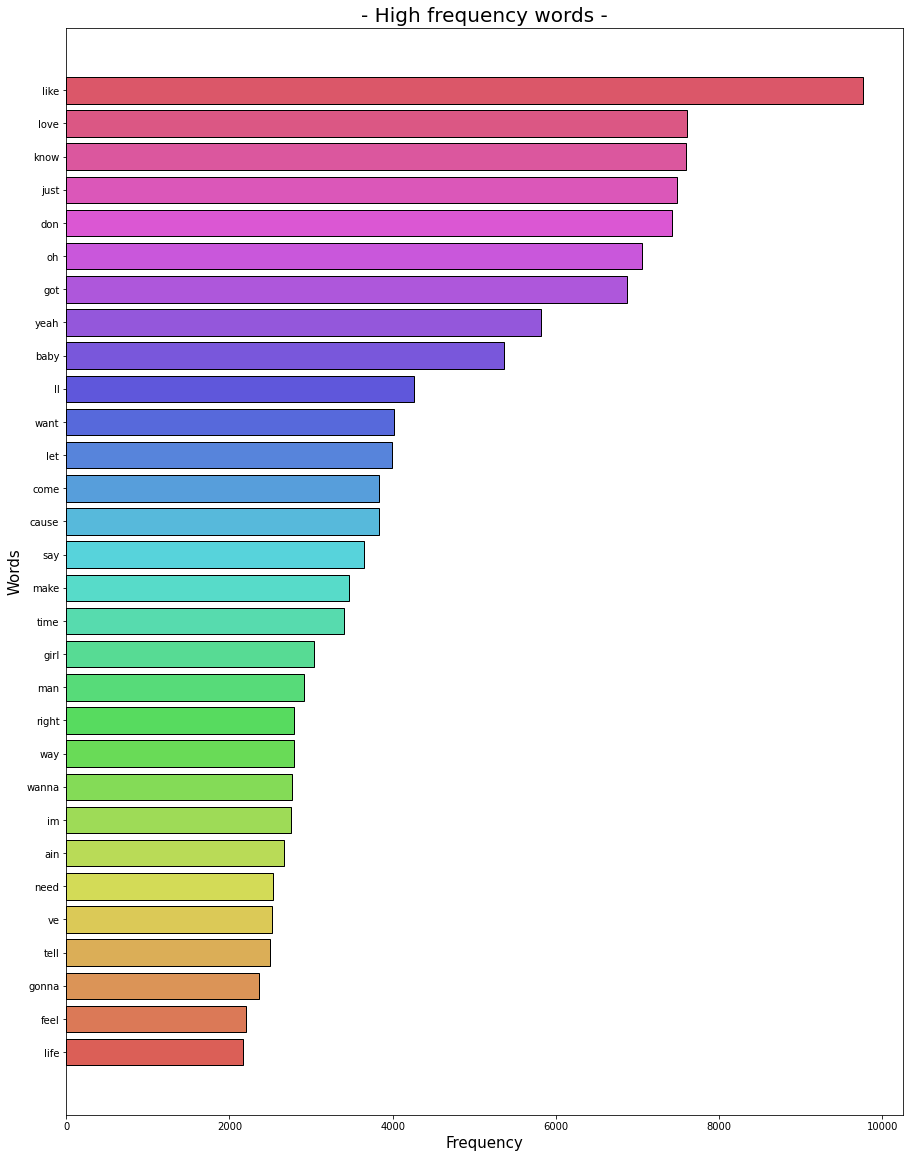

In [ ]:
# 위에서 만든 데이터프레임을 통해서 그래프로 생성
import matplotlib.pyplot as plt
import seaborn as sns

# 30개까지의 결과를 보고 싶어서 슬라이싱
word_30 = word_df[0:30] 
word_30 = word_30.sort_values('Frequency', ascending=True)

# 막대 그래프로 얼만큼의 단어가 각기 빈도 별로 분포되어있는지 시각화
plt.figure(figsize=(15,20))
colors = sns.color_palette('hls',len(word_30))
plt.barh(word_30['Word'], word_30['Frequency'], color=colors, edgecolor='black')
plt.title('- High frequency words -', fontsize=20)
plt.xlabel('Frequency', fontsize=15)
plt.ylabel('Words', fontsize=15)
plt.show()

* 가로형 막대그래프는 상대적으로 세로형보다 훨씬 많은 자료들을 한눈에 볼 수 있게 해주기 때문에 단어의 빈도수를 측정하기에 매우 유용한 구조였다. 앞서 봤던 'like', 'love', 'know' 말고도 'don't', 'oh', 'got', 'yeah', 'baby' 같은 글자들이 뒤를 이었는데 그 중에서도 'oh' 나 'yeah' 같은 경우는 아무래도 노래 가사기 때문에 추임새가 추가적으로 많이 쓰이는게 아닌가 싶은 추측을 하게 만들었다. 'don'의 경우 앞서 정규표현식에 의해서 뒤에 't'가 잘려나간 형태기 때문에 자연스럽게 본래 어떤 단어였는지를 유추할 수 있었는데 확실히 명사보다는 동사가 훨씬 많이 쓰이는 것을 확인할 수 있었다.

* 개인적으로 의외였던 건 'girl'이 상위권인데 비해 'boy'는 상위권에 없었던 점과 더불어 'man'이 상위권인 반면에 'woman'이 순위권에 없었다는 점이었는데, 이 명사들이 나잇대로 구분되어 쓰이는 건지 아닌지에 대한 묘한 호기심이 들게 만들었다....

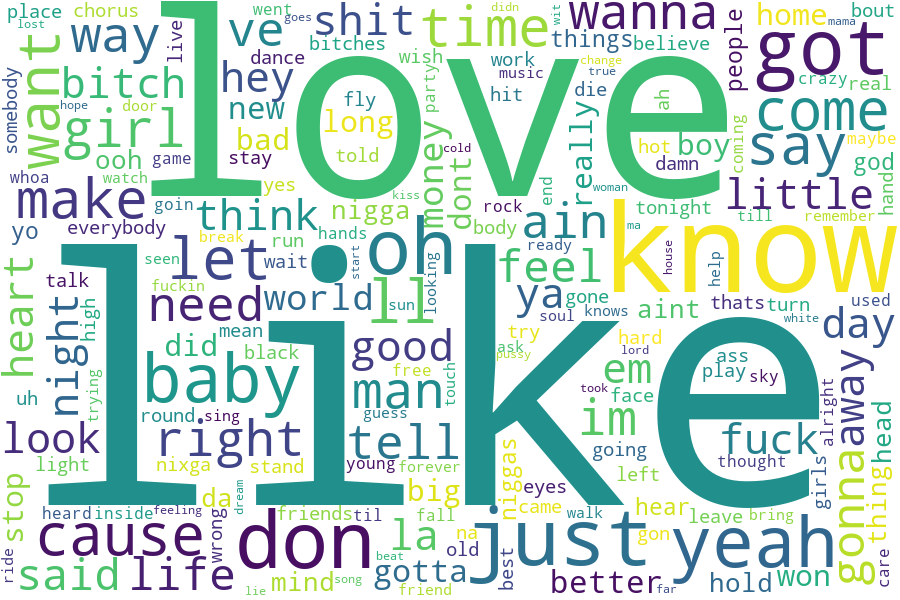

In [ ]:
# wordcloud를 이용한 단어 시각화를 위해 wordclod 모듈 로드
from wordcloud import WordCloud

# 그래프를 노트북과 함께 저장
%matplotlib inline 

# 앞서 단어 갯수를 미리 세뒀기 때문에 간단하게 단어구름을 출력할 수 있다
wc = WordCloud(background_color='white', width=900, height=600)
cloud = wc.fit_words(dict(word_count))
cloud.to_image()

* 마지막으로 Nlp의 그래프라고 하면 가장 대표되는 종류 중 하나인 'wordcloud'로도 빈도수별로 출력해봤는데, 확실히 트렌디하면서도 크기에 따라 어떤 단어들이 많이 나왔는지를 제대로 볼 수 있어서 앞서 본 막대그래프만큼이나 유용했다. 거기다가 빈도수가 낮아서 상대적으로 적게 나오는 단어들까지 고루 출력되기 때문에 대체로 어떤 내용의 노래들이 현재 데이터로 주어진 문장들 속에 포함되어 있는지를 한눈에 파악할 수 있었다.

* 결국 단어의 빈도수와 전체적인 흐름으로 미루어보아 내용의 문맥상 사랑 노래가 압도적으로 많았다는 게 시각화에서의 결론이다.

<br>

### Step 3. 데이터 정제

In [55]:
# 정규표현식을 이용해서 문장들을 정리(특수문자 제거에 유의)
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1 소문자로 바꾸고, 양쪽 공백 삭제
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2 특수문자 양쪽에 공백 삽입
    sentence = re.sub(r'[" "]+', " ", sentence) # 3 여러개의 공백은 하나의 공백으로 교체
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4 a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 통일
    sentence = sentence.strip() # 5 다시 양쪽 공백 삭제
    sentence1 = sentence.split(' ')

    # 갯수가 14개 이하의 문장들만을 추려낸다
    if len(sentence1) > 13: 
        return 0
    else:
        sentence = '<start> ' + sentence + ' <end>' # 6 문장 시작에는 <start>, 끝에는 <end>를 추가
        return sentence

* 여기서 문장의 길이가 15개 이하를 꼽아내는데 왜 13 이상의 문장 수들을 제외하냐면, 'start'와 'end'를 포함해서 15가 되어야 하기 때문에 13자리까지로 설정하는게 맞겠다고 생각했다.

In [56]:
# 문장이 어떻게 필터링되는지 체크
print(preprocess_sentence("This @_is ;;;sample        sentence."))

<start> this is sample sentence . <end>


In [57]:
# 앞서 정제된 문장들 중에서 필요한 문장들만 다시 리스트로 추려낸다.
corpus = []

for sentence in raw_corpus: # 반복하면서 원하지 않는 문장은 패스
    if len(sentence) == 0: continue
    if sentence[-1] == ":": continue
    
    preprocessed_sentence = preprocess_sentence(sentence)
    if preprocessed_sentence ==0:
        pass
    else:
        corpus.append(preprocess_sentence(sentence))
                
# 졍제된 문장을 10개 정도만 확인
corpus[:10]

['<start> looking for some education <end>',
 '<start> made my way into the night <end>',
 '<start> all that bullshit conversation <end>',
 '<start> i don t even wanna waste your time <end>',
 '<start> let s just say that maybe <end>',
 '<start> you could help me ease my mind <end>',
 '<start> if that s love in your eyes <end>',
 '<start> it s more than enough <end>',
 '<start> had some bad love <end>',
 '<start> ooh , ooh looking for some affirmation <end>']

<br>

### Step 4. 평가 데이터셋 분리

In [58]:
# 단어를 토큰화(벡터화) 시키기
def tokenize(corpus):   #tokenizer를 이용해 corpus를 텐서로 만드는 함수
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=18000, # 단어장의 크기는 18000 정도
        filters=' ', # 앞서 전처리를 진행했으니 따로 filter를 쓰지 않는다.
        oov_token="<unk>" # 담기지 않은 단어들은 unk로 통일
    )
    
    # 단어장 완성하기
    tokenizer.fit_on_texts(corpus)   
    tensor = tokenizer.texts_to_sequences(corpus)       
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post') # padding을 붙여서 공백을 맞춘다
    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[    2   290    28 ...     0     0     0]
 [    2   219    13 ...     0     0     0]
 [    2    25    15 ...     0     0     0]
 ...
 [    2   233 17295 ...     0     0     0]
 [    2    10   501 ...     0     0     0]
 [    2   121    19 ...     0     0     0]] <keras_preprocessing.text.Tokenizer object at 0x7f2d6609eb90>


* 여기서 데이터 시퀀스 길이를 일정하게 맞춰주는데, 시퀀스가 짧을 경우에는 문장 뒤쪽에 공백(패딩)을 붙여서 동일하게 길이를 맞춰주는 작업을 한다.

In [60]:
tensor.shape #tensor로 변환된 후의 크기를 확인

(156013, 15)

In [ ]:
# 제대로 바뀌었는지 확인을 위해 tensor 일부를 체크
print(tensor[:10, :10])

[[    2   290    28    94  4486     3     0     0     0     0]
 [    2   219    13    86   221     6   113     3     0     0]
 [    2    25    15  1038  2249     3     0     0     0     0]
 [    2     4    40    16   158    89  1089    19    76     3]
 [    2    67    17    32    71    15   292     3     0     0]
 [    2     7   104   313    12  1652    13   181     3     0]
 [    2    51    15    17    36    14    19   195     3     0]
 [    2    11    17    98   166   255     3     0     0     0]
 [    2   110    94   157    36     3     0     0     0     0]
 [    2   190     5   190   290    28    94 12440     3     0]]


* 여기서는 문장이 어떻게 구성되는지를 체크할 수 있었는데, 의아한 점이 있다. 대부분의 문장들이 다 인덱스 '2'로 시작한다는 점이었는데, '2' 에 들어가는 인덱스는 무슨 역할을 하는지 궁금해진다.

In [ ]:
# 단어 사전의 인덱스 체크
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 15: break # 15번째까지의 index를 추출

1 : <unk>
2 : <start>
3 : <end>
4 : i
5 : ,
6 : the
7 : you
8 : and
9 : a
10 : to
11 : it
12 : me
13 : my
14 : in
15 : that


* [   2  304   28   99 4811    3    0    0    0    0]
= 앞에 '2'로 시작하는 건 인덱스에서 <start>로 시작한다는 뜻이고, 마지막에는 '3'인 <end>로 끝나는 것을 확인할 수 있다. 뒤에는 padding으로 공백이 들어가기 때문에 3뒤에 [ 0 0 0 0 ]이 들어가서 모든 문장들의 길이를 맞춰둔 것을 체크해볼 수 있었다.

In [61]:
# tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성. 
# 여기서 마지막 토큰은 <end>가 아니라 <pad>일 가능성이 높음
src_input = tensor[:, :-1]

# tensor에서 <start>를 잘라내서 타겟 문장을 생성
tgt_input = tensor[:, 1:]
  
print(src_input[0])
print(tgt_input[0])

[   2  290   28   94 4486    3    0    0    0    0    0    0    0    0]
[ 290   28   94 4486    3    0    0    0    0    0    0    0    0    0]


In [115]:
# 에폭 돌리는 동안 history 시각화를 위한 함수 생성
def epochs_history(epochs, hist, list_of_metrics):
    
    fig, ax = plt.subplots(1,2, figsize = (15, 10))
    
    for i in range(len(ax)):
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel('Value')
        
        for n in range(len(list_of_metrics)):
            if i == 0:
                y = hist[list_of_metrics[n]]                
                if n == 0:
                    ax[i].plot(epochs, y, label="train")                
                else:
                    ax[i].plot(epochs, y, color = 'red', label="val")
                ax[i].set_title('- Loss -')
                ax[i].legend(loc='upper right')                               

                if n == 1:
                    break
            else:
                if n >= 2:
                    y = hist[list_of_metrics[n]]
                    
                    if n == 2:
                        ax[i].plot(epochs, y, label="train")
                    else:
                        ax[i].plot(epochs, y, color = 'red', label="val")
                    ax[i].set_title('- Accuracy -')
                    ax[i].legend(loc='lower right')                 
    
    plt.show()

In [62]:
# test셋과 train셋을 분리(test셋은 20퍼센트로 분리)
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, 
                                                          tgt_input, 
                                                          test_size=0.2, 
                                                          random_state=42)

In [63]:
# 데이터셋 객체를 생성
BUFFER_SIZE = len(enc_train)
BATCH_SIZE = 256
steps_per_epoch = len(enc_train) // BATCH_SIZE

VOCAB_SIZE = tokenizer.num_words + 1   

# 텐서플로우를 활용해 객체를 생성
dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
val_dataset = tf.data.Dataset.from_tensor_slices((enc_val, dec_val)).shuffle(BUFFER_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)

print(dataset)
print(val_dataset)

<BatchDataset element_spec=(TensorSpec(shape=(256, 14), dtype=tf.int32, name=None), TensorSpec(shape=(256, 14), dtype=tf.int32, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(256, 14), dtype=tf.int32, name=None), TensorSpec(shape=(256, 14), dtype=tf.int32, name=None))>


![20220514231748](https://user-images.githubusercontent.com/100528803/168429733-3e98d823-2ca5-4b1d-9c3c-f168cb22a66f.png)

* 위의 코드는 앞서 노션에 있는 [ 프로젝트 노드 제출 관련 Tip >>>>>> 노래 만들기가 너무 쉬울때 1번 ]을 참고했습니다.

In [64]:
# 분리된 데이터 체크
print("- Train dataset:", enc_train.shape)
print("- Train label:", dec_train.shape)
print("- Validation dataset:", enc_val.shape)
print("- Validation label:", dec_val.shape)

- Train dataset: (124810, 14)
- Train label: (124810, 14)
- Validation dataset: (31203, 14)
- Validation label: (31203, 14)


* 각기 train과 test 데이터가 정상적으로 분리되어 있는 것을 확인.

![20220514231759](https://user-images.githubusercontent.com/100528803/168429645-40636fbd-0065-4f9c-84e8-1118453360c3.png)

* 위의 코드는 앞서 노션에 있는 [ 프로젝트 노드 제출 관련 Tip >>>>>> 노래 만들기가 너무 쉬울때 2번 ]을 참고했습니다. 그렇게 해서 각기 Source Train과 Target Train을 일치 시켜서 동일한 조건에서의 모델을 시험할 준비는 끝낸 상태입니다.

<br>

### Step 5. 인공지능 만들기

In [94]:
# embedding Size, Hidden Size를 조절하면서 10 Epoch 안에 val loss값 2.2 수준으로 줄일 수 있는 모델 설계
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.drop1 = tf.keras.layers.Dropout(0.4) # dropout을 추가1 
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.drop2 = tf.keras.layers.Dropout(0.4) # dropout을 추가2
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.drop1(out)
        out = self.rnn_2(out)
        out = self.drop2(out)
        out = self.linear(out)
        
        return out

# 수치는 여기서 변경(일단은 노드 상에 나온 가장 기본값으로 먼저 설정해서 바꿀 예정)
embedding_size = 2048 # 노드 기본값은 256이었는데 512 > 1024 > 2048 로 늘린 상태
hidden_size = 2048 # 노드 기본값은 1024였는데 돌리면서 2048로 늘렸다
lyricist = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

* 수치 조절을 위한 각각의 설명 
1. embedding_size : 워드 벡터의 차원수, 단어가 추상적으로 표현되는 크기. 충분한 데이터가 없다면 비효율적이기 때문에 노드에서는 256으로 설정된 상태

2. hidden_size : hidden state의 차원수, 모델에 얼마나 많은 일꾼으로 둘 것인가로 설명되어 있었다. 충분한 데이터가 주어질수록 더 정확한 결정이 나오는데 노드상에서는 1024로 설정된 상태

In [95]:
# 데이터셋에서 데이터 한 배치만 가져온다
for src_sample, tgt_sample in dataset.take(1): break

# 한 배치만 불러온 데이터를 모델에 넣기
lyricist(src_sample)

<tf.Tensor: shape=(256, 14, 18001), dtype=float32, numpy=
array([[[-3.9423598e-04, -3.1149134e-04, -6.3224399e-04, ...,
          2.9359091e-04, -5.9536018e-05,  2.4289511e-04],
        [-6.7302742e-04,  1.4933008e-04, -7.7782135e-04, ...,
          5.9397373e-04, -1.7151701e-04, -5.9277413e-04],
        [-9.4854087e-04,  6.7152298e-04, -4.6256321e-04, ...,
          1.1217077e-03, -7.8981550e-04, -4.5714990e-04],
        ...,
        [ 1.6007393e-03,  3.0336186e-04, -3.4360407e-04, ...,
         -2.4539654e-03,  1.4293005e-03, -9.4797264e-04],
        [ 2.3527257e-03,  1.8390291e-04, -8.9940644e-04, ...,
         -2.8772578e-03,  1.9201947e-03, -7.3705189e-04],
        [ 3.0684217e-03,  7.9347352e-05, -1.4732726e-03, ...,
         -3.2499598e-03,  2.4256399e-03, -5.2962557e-04]],

       [[-3.9423598e-04, -3.1149134e-04, -6.3224399e-04, ...,
          2.9359091e-04, -5.9536018e-05,  2.4289511e-04],
        [-7.0431200e-04,  2.1445623e-04, -7.2936784e-04, ...,
         -2.3293374e-04, 

* 여기서 (256, 14, 18001)는 배치사이즈 256, 앞서 더 긴 문장들을 제외시키고 시퀀수의 길이를 정해둠에 따라 단어는 최대 14개씩 들어가며, Dense 레이어에서의 출력 차원수는 18001, 즉 단어장의 갯수를 의미한다. 쨌든 텐서로 전환되서 잘 나오는 것을 다시 체크할 수 있었다.

In [96]:
# 모델의 정보를 확인
lyricist.summary()

Model: "text_generator_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     multiple                  36866048  
                                                                 
 lstm_12 (LSTM)              multiple                  33562624  
                                                                 
 dropout_5 (Dropout)         multiple                  0         
                                                                 
 lstm_13 (LSTM)              multiple                  33562624  
                                                                 
 dropout_6 (Dropout)         multiple                  0         
                                                                 
 dense_6 (Dense)             multiple                  36884049  
                                                                 
Total params: 140,875,345
Trainable params: 140,87

In [77]:
# [프로토] dropout레이어 1개 추가,  embedding_size 512 > 1024, hidden_size = 2048 이었을 때의 모델 결과

# optimizer는 Adam, loss함수는 Crossentropy로 설정해서 모델을 돌린다
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

lyricist.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
# 10 에폭 안에 val_loss 값을 2.2 수준으로 줄이라고 했으므로 여기서 가능한지 테스트

Epoch 1/10
487/487 [==============================] - 177s 354ms/step - loss: 3.3235 - accuracy: 0.5028 - val_loss: 2.9423 - val_accuracy: 0.5310
Epoch 2/10
487/487 [==============================] - 172s 353ms/step - loss: 2.7604 - accuracy: 0.5419 - val_loss: 2.6860 - val_accuracy: 0.5537
Epoch 3/10
487/487 [==============================] - 172s 352ms/step - loss: 2.4258 - accuracy: 0.5708 - val_loss: 2.5051 - val_accuracy: 0.5766
Epoch 4/10
487/487 [==============================] - 172s 352ms/step - loss: 2.1176 - accuracy: 0.6053 - val_loss: 2.3790 - val_accuracy: 0.5993
Epoch 5/10
487/487 [==============================] - 172s 352ms/step - loss: 1.8518 - accuracy: 0.6429 - val_loss: 2.2907 - val_accuracy: 0.6191
Epoch 6/10
487/487 [==============================] - 172s 353ms/step - loss: 1.6320 - accuracy: 0.6795 - val_loss: 2.2404 - val_accuracy: 0.6345
Epoch 7/10
487/487 [==============================] - 176s 362ms/step - loss: 1.4565 - accuracy: 0.7116 - val_loss: 2.2110 -

* ......솔직히 val_loss 2.20까지 나왔을때는 아 됐다 끝났다하고 시간과의 싸움에서 만족하고 있었는데 10번째 결과에서 너무 벙쩌버려서.... 눈물을 머금고 다시 돌려야했다(한번 돌리는데 30분이 걸렸기 때문에 좀 더 전략적인 모델의 구축이 필요했다)

In [97]:
# [본 모델] dropout레이어 2개 추가,  embedding_size 1024 > 2048, hidden_size = 2048 이었을 때의 모델 결과

# 몇 번의 오버피팅 끝에 더 이상의 오버핏을 막고자 Early Stopping을 추가
from keras.callbacks import EarlyStopping

# 조기 종류의 조건은 val_loss가 더이상 낮아지지 않을때로 지정 (3번이상 값이 좋아지지 않을 경우 epoch 종료)
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',
                                           patience=3)]

# optimizer는 Adam, loss함수는 Crossentropy로 설정해서 모델을 돌린다
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

lyricist.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

# 시각화를 위해서 history도 추가
history = lyricist.fit(dataset,
          epochs=10,
          validation_data=val_dataset,
          callbacks=callbacks,
          verbose=1)
# 10 에폭 안에 val_loss 값을 2.2 수준으로 줄이라고 했으므로 여기서 가능한지 테스트

Epoch 1/10
487/487 [==============================] - 190s 385ms/step - loss: 3.2692 - accuracy: 0.5077 - val_loss: 2.9046 - val_accuracy: 0.5352
Epoch 2/10
487/487 [==============================] - 187s 383ms/step - loss: 2.7695 - accuracy: 0.5440 - val_loss: 2.6708 - val_accuracy: 0.5566
Epoch 3/10
487/487 [==============================] - 187s 383ms/step - loss: 2.4864 - accuracy: 0.5677 - val_loss: 2.4998 - val_accuracy: 0.5776
Epoch 4/10
487/487 [==============================] - 186s 382ms/step - loss: 2.2312 - accuracy: 0.5938 - val_loss: 2.3772 - val_accuracy: 0.5957
Epoch 5/10
487/487 [==============================] - 186s 382ms/step - loss: 2.0196 - accuracy: 0.6190 - val_loss: 2.2936 - val_accuracy: 0.6122
Epoch 6/10
487/487 [==============================] - 186s 382ms/step - loss: 1.8452 - accuracy: 0.6434 - val_loss: 2.2375 - val_accuracy: 0.6259
Epoch 7/10
487/487 [==============================] - 186s 382ms/step - loss: 1.7068 - accuracy: 0.6650 - val_loss: 2.2049 -

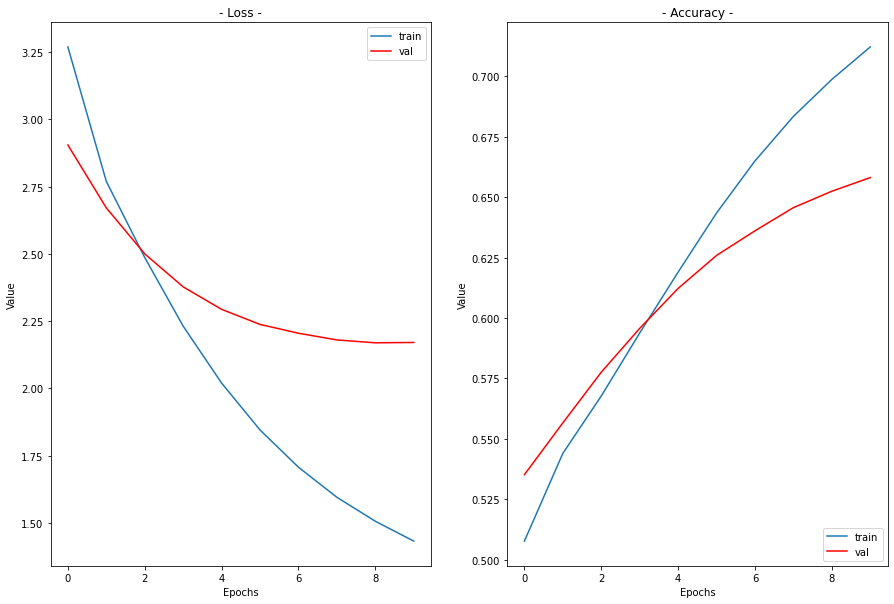

In [116]:
# loss값을 추출해서 그래프로 실제 어떻게 떨어지는지를 확인하기
epochs_history(history.epoch, history.history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

* 에폭이 점차 진행됨에 따라 학습 데이터와 검증 데이터 모두 쭉 내려가는 걸 확인할 수 있었는데, epoch을 몇번 돌러본 결과 검증데이터였던 val_loss는 그냥 loss값보다는 상대적으로 잘 내려가지 않는 걸 확인할 수 있었다. 그럼에도 최종적인 val_loss값은 하이퍼 파라미터를 바꿔서 돌린 결과 [ 2.1705 ]가 나왔으므로 만족스럽게 훈련이 된 상태라고 판단할 수 있다.

In [ ]:
# 입력받은 init_sentence도 텐서로 변환
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]
    
    # 단어 하나씩 예측해 문장을 제작
    while True:
        predict = model(test_tensor) #1. 입력받은 문장의 텐서를 입력
        # 예측된 값 중 가장 높은 확률인 word index를 뽑기
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 예측된 word index를 문장 뒤에 붙이기
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)

        # 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 종료
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

In [ ]:
# 제대로 문장이 나오는지 확인 + 그 김에 서로 다른 단어들을 맨 앞으로 조합

print(generate_text(lyricist, tokenizer, init_sentence='<start> he', max_len=15))
print(generate_text(lyricist, tokenizer, init_sentence='<start> she', max_len=15))
print(generate_text(lyricist, tokenizer, init_sentence='<start> i', max_len=15))
print(generate_text(lyricist, tokenizer, init_sentence='<start> you', max_len=15))
print(generate_text(lyricist, tokenizer, init_sentence='<start> who', max_len=15))
print(generate_text(lyricist, tokenizer, init_sentence='<start> where', max_len=15))
print(generate_text(lyricist, tokenizer, init_sentence='<start> why', max_len=15))
print(generate_text(lyricist, tokenizer, init_sentence='<start> may', max_len=15))
print(generate_text(lyricist, tokenizer, init_sentence='<start> try', max_len=15))

<start> he s got a little farther <end>
<start> she s got me runnin round and round and round <end>
<start> i m a negative creep <end>
<start> you know i m a motherfucking monster <end>
<start> who s the one <end>
<start> where the eyelids go <end>
<start> why don t you know <end>
<start> may i be the one <end>
<start> try to make a better place <end>


![20220515005250](https://user-images.githubusercontent.com/100528803/168439289-9020c7d3-90e2-49a7-a6de-7424e81257e4.png)

* 정작 'love' 내지는 'like' 가 들어간 게 하나도 없는데도 불구하고 앞서 생략했던 부호들을 다시 추가하고 나니 묘하게 사랑노래로 변해버린 건 안비밀.... 대충 줄거리만 보자면 ' 나쁜 남자인 내 자신 너한테 꽂힘 왜 모르니? 내가 노력할거야' 정도의 뉘앙스가 된 탓에 지난 대세에 부합하는 내용으로 완성된 사실에 놀랐다......... 역시 유명한 가사집들을 넣어서 그런가 결과물 조차도 힙한 감성이 튀어나온 것 같다.(개인적으로 나쁜 사람 계통을 안 좋아하는 관계로 별로 공감은 안가지만 모델의 취향... 존중해주기로 하자)

<br>


## ✔️회고 및 결론
---

#### ▶️ 이번 프로젝트에서 어려웠던 점

단어를 18000개씩이나 추려냈는데 중간에 취합되지 않은 단어가 있는지 'unk' 라고 뜨는게 묘하게 신경쓰였다. 사실 초기값은 앞서 노드에서 정해둔 12000 정도로 했었는데, 그때는 'unk'가 더 많이 떴었고 고심 끝에 단어장을 늘린 거였는데, 이 정도도 단어가 모두 구현되지 않는다면 몇십만 개 가까이되어야 가능한건가 싶어서 제대로 된 긴 문장 구현은 과연 가능할까가 의문이 드는 순간이었다.

<br>

#### ▶️ 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점

처음부터 모델이 깔끔하게 나온건지 [ embedding_size ]와 [ hidden_size ]의 기본값만으로도 성능이 잘 나와서 조금 놀랐다. 그래서 노션에 있는 '노래만들기가 너무 쉬울 때'까지 적용해서 거의 동일한 모델을 구현하려고 노력했는데 이조차도 깔끔하게 마무리지어서 한편으로는 깔끔한 데이터가 편리하다는 걸 재차 확인하게 된 순간이었다.

![dddddd](https://user-images.githubusercontent.com/100528803/168445108-99572720-6cea-43a6-9052-86e3bbf24165.png)


앞서 본 것처럼 데이터를 본격적으로 돌리기 전에 문장들이 어떤 단어로 이루어져 있는지에 대해 쭉 훑어봤는데, 역시 가사들은 사랑노래가 가장 많고 보편적이라서 그런지 완성된 내용까지도 비슷한 내용이라 사용된 데이터 만큼이나 정직한 결과가 나왔다는 걸 다시 실감하게 만들었다. 심지어 빈도수가 높은 단어들을 일부러 조금씩 제외하고서 단어를 던져줬음에도 불구하고 맥락이 엇비슷하다는 점은 이 모델이 큰 맥락을 어느정도 학습하고 있음에 대한 반증이 아닐까 막연히 추측하게 했다.

<br>


#### ▶️ 루브릭 평가 지표를 맞추기 위해 시도한 것들

이번 프로젝트에서 루브릭의 기준은 아래와 같았다.

|       |                                    **< 평가문항 >**                                   |                                                              **< 상세기준 >**                                                             |
|-------|:---------------------------------------------------------------------------------|:-------------------------------------------------------------------------------------------------------------------------------------|
| **1** | 가사 텍스트 생성 모델이 정상적으로 동작하는가?<br>                                 | 텍스트 제너레이션 결과가 그럴듯한 문장으로 생성되는가?<br>                                                        |
| **2** | 데이터의 전처리와 데이터셋 구성 과정이 체계적으로 진행되었는가?<br> | 특수문자 제거, 토크나이저 생성, 패딩처리 등의 과정이 빠짐없이 진행되었는가?                             |
| **3** | 텍스트 생성모델이 안정적으로 학습되었는가?                                    | 텍스트 생성모델의 validation loss가 2.2 이하로 낮아졌는가? |

In [119]:
print(f'- 최종 모델의 [ Validation loss ]값은 [{val_loss}]으로, 2.2 이하의 조건을 충족했습니다.')

- 최종 모델의 [ Validation loss ]값은 [ 2.1705 ]으로, 2.2 이하의 조건을 충족했습니다.



![20220519223951](https://user-images.githubusercontent.com/100528803/169321827-ceee113d-2014-439a-92d4-3673c30ba7fd.png)

5번째쯤 파라미터를 수정해서 돌렸을때 거의 다 됐다고 생각했던 순간이 있었다. 그런데 갑자기 값이 직전 루브릭을 만족하는 조건에서 치솟는 걸 보면서 대체 뭐가 문제지? 를 고민하게 만들었다.

![20220519224902](https://user-images.githubusercontent.com/100528803/169316760-c0c66d9d-0b6a-4239-a788-048ac3e6bf99.png)

원래 [ 5번째 모델 ]은 드롭아웃을 1번 적용한 모델이었다. [ 6번째 모델(마지막) ]에는 임베딩 사이즈도 2048로 늘리고, 히든 사이즈도 동일하게 통일시켰는데 솔직히 이 둘도 미세한 차이는 있었지만 결정적으로 2.2 마의 구간을 뚫게 만든 계기는 2번째 드롭아웃 추가였다. 사실 배우기를 요즘에는 드롭아웃 자체를 많이 안쓴다고는 했는데, 레이어를 확률적으로 끄고 키는 것만으로도 val_loss가 잡혔다면, 어딘가 히든층 다른 구간에서 더 의존적이었을 수도 있는 연결 부분이 고르게 분산되었기 때문에 소폭 좋아진 게 아닌가라는 생각을 들게 만들었다.

일단 텍스트 제네레이션에서 나온 문장들이 전체적으로 얼개가 맞았다는 점에서 기본적인 사항은 넘긴 것 같고, 앞서 패딩처리와 특수문자 제거, 토크나이저의 경우 기본적인 노드에서의 내용과 일치하기 때문에 달리 어려운 지점은 없었다. 다만 마지막의 텍스트 생성모델의 val_loss 값이 2.2 에서 오락가락해서 그게 좀 까다로웠는데, 그래도 2.1 정도로 아슬아슬하게 내려갔기에 최종적으로 기준에 맞춤으로서 루브릭에서의 모든 사항을 만족했다.


<br>

#### ▶️ 자기 다짐

저번 세미나에서 NLP Transformer관련을 다루시는 분께 질의응답을 한 적이 있었는데, 아무래도 국문과거나 언어에 대해 잘 아는 사람일수록 NLP에는 더 유리할 수 있다는 답을 들은 적이 있었다. 그렇다보니 중국어 버전 모델과 다른 국가별 모델이 조금씩 얼개가 다를 수 있다는 부분에서 NLP는 기본적인 언어의 구조를 같이 공부해야 더 효율적으로 다룰 수 있는 게 아닌가 다시금 상기하게 했던 프로젝트였다.

<br>

## ✔️Reference(참고자료)
---
* https://omicro03.medium.com/%EC%9E%90%EC%97%B0%EC%96%B4%EC%B2%98%EB%A6%AC-nlp-12%EC%9D%BC%EC%B0%A8-ltsm-81c9751afafb
* https://velog.io/@tmddn0311/mnist-classification
* https://docs.python.org/ko/3.8/library/itertools.html
* https://github.com/alwaysmindy/aiffel_exploration/blob/fdad316dfea47d0a5e9b130cd98e181334fef738/exploration3_lstm_lyrics.ipynb
* http://doc.mindscale.kr/km/unstructured/un03.html
* https://jtoday.tistory.com/83
* https://www.youtube.com/watch?v=2e9wnwuAVv0
* https://wikidocs.net/33661
